Files already downloaded and verified
Files already downloaded and verified
Training Started
epoch1 - 1steps loss: 2.308133840560913
epoch1 - 1001steps loss: 1.3504865169525146
epoch1 - 1563steps loss: 1.5324723720550537
Training Done
Evaluation Started
Accuracy : 55.074 %


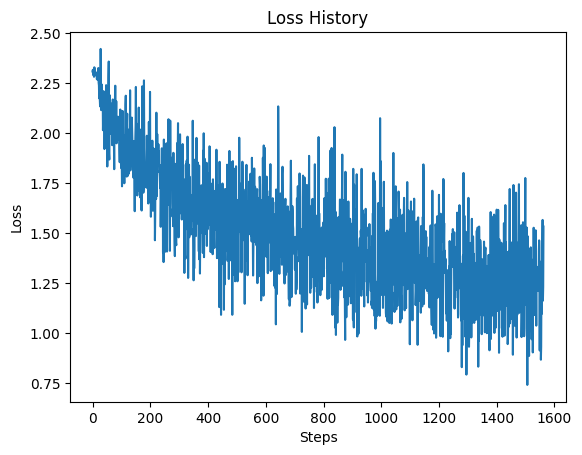

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
import torch.optim


import numpy as np
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

import dataset
import model_store

# store hyper parameters
hparams  = {
    "model": "CNN",
    "detaset": "CIFAR-10",
    "optimizer": "Adam",
    "momentum": 0.9,
    "epochs": 1,
    "train_batch_size": 32,
    "eval_batch_size": 32,
    "lr": 1e-3,
    "checkpoint": 1000,
}

# avalable GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# get dataset
train, test = dataset.get_dataset(hparams["detaset"])
train_loader = torch.utils.data.DataLoader(
                train,
                batch_size=hparams["train_batch_size"],
                shuffle=True,
                num_workers=2)

test_loader = torch.utils.data.DataLoader(
                test,
                batch_size=hparams["eval_batch_size"],
                shuffle=False,
                num_workers=2)

hparams["n_classes"] = len(train.classes)
hparams["input_shape"] = train[0][0].shape

# get model
model = model_store.get_model(hparams).to(device)

# get optimizer
if hparams["optimizer"] == "SGD":
    optimizer = torch.optim.SGD(model.parameters(), lr=hparams["lr"], momentum=hparams["momentum"])
elif hparams["optimizer"] == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=hparams["lr"])

criterion = nn.CrossEntropyLoss()

print("Training Started")
# training phase
history = []
for epoch in range(hparams["epochs"]):

    for i, data in enumerate(train_loader, 0):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        loss = F.cross_entropy(model(images), labels)
        history.append(loss.item())
        loss.backward()
        optimizer.step()

        if i % hparams["checkpoint"] == 0 or i == len(train_loader) - 1:
            print(f"epoch{epoch + 1} - {i + 1}steps loss: {loss}")

print("Training Done")

print("Evaluation Started")
# test phase
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        logits = model(images)
        pred_label = logits.argmax(dim=1)
        total += labels.size(0)
        correct += (pred_label == labels).sum().item()

print(f'Final Test Accuracy : {100 * correct / total} %')

plt.plot(history)
plt.title("Loss History")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()